In [1]:
import pandas as pd

df = pd.read_csv('AC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-03-30,2.220000,2.27,2.220000,2.220000,2.220000,783200.0
1,2010-03-31,2.250000,2.25,2.100000,2.220000,2.220000,967000.0
2,2010-04-01,2.250000,2.50,2.250000,2.450000,2.450000,3302800.0
3,2010-04-05,2.510000,2.67,2.500000,2.520000,2.520000,2309000.0
4,2010-04-06,2.580000,2.60,2.540000,2.550000,2.550000,661000.0
...,...,...,...,...,...,...,...
3115,2022-08-29,17.950001,18.26,17.799999,18.010000,18.010000,1228800.0
3116,2022-08-30,18.129999,18.42,17.840000,18.090000,18.090000,1466500.0
3117,2022-08-31,18.110001,18.25,17.680000,17.690001,17.690001,1961800.0
3118,2022-09-01,17.350000,17.65,17.090000,17.600000,17.600000,2405200.0


In [2]:
df = df[['Date', 'Close']]
df

,Date,Close
0,2010-03-30,2.220000
1,2010-03-31,2.220000
2,2010-04-01,2.450000
3,2010-04-05,2.520000
4,2010-04-06,2.550000
...,...,...
3115,2022-08-29,18.010000
3116,2022-08-30,18.090000
3117,2022-08-31,17.690001
3118,2022-09-01,17.600000


In [3]:
import datetime

def toDT(s):
    split = s.split('-')
    y = int(split[0])
    m = int(split[1])
    d = int(split[2])
    return datetime.datetime(y, m, d)

df['Date'] = df['Date'].apply(toDT)
df['Date']
df.index = df.pop('Date')
df

/var/folders/v2/_g6q28q55h79nr1gdy34x1l00000gn/T/ipykernel_2561/1043190241.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(toDT)


,Close
Date,
2010-03-30,2.220000
2010-03-31,2.220000
2010-04-01,2.450000
2010-04-05,2.520000
2010-04-06,2.550000
...,...
2022-08-29,18.010000
2022-08-30,18.090000
2022-08-31,17.690001


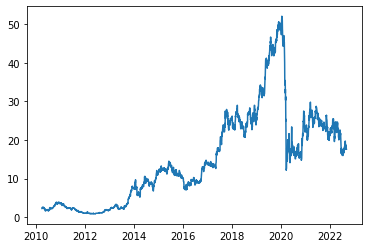

In [4]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [19]:
import numpy as np

def dfToWindowed(dataframe, fDateStr, lDateStr, n=3):
    fDate = toDT(fDateStr)
    lDate = toDT(lDateStr)
    
    tarDate = fDate
    
    dates = []
    X = []
    Y = []
    
    last = False
    while True:
        df_subset = dataframe.loc[:tarDate].tail(n+1)
        
        if len(df_subset) != n+1:
            print('Error: Window size ', n, ' is too large for date ', tarDate)
            return
        
        vals = df_subset['Close'].to_numpy()
        x = vals[:-1]
        y = vals[-1]
        
        dates.append(tarDate)
        X.append(x)
        Y.append(y)
        
        nextWeek = dataframe.loc[tarDate:tarDate+datetime.timedelta(days=7)]
        nextDatetime= str(nextWeek.head(2).tail(1).index.values[0])
        nextDate_str = nextDatetime.split('T')[0]
        yearMonthDay = nextDate_str.split('-')
        year, month, day = yearMonthDay
        nextDate = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last:
            break
        
        tarDate = nextDate
        
        if tarDate == lDate:
            last = True;
            
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
        
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df['Target-', n-i] = X[:, i]
            
    ret_df['Target'] = Y
        
    return ret_df
    
windowed = dfToWindowed(df, '2021-09-07', '2022-09-02', n=3)
windowed

,Target Date,"(Target-, 3)","(Target-, 2)","(Target-, 1)",Target
0,2021-09-07,24.270000,24.110001,24.020000,24.129999
1,2021-09-08,24.110001,24.020000,24.129999,23.490000
2,2021-09-09,24.020000,24.129999,23.490000,24.059999
3,2021-09-10,24.129999,23.490000,24.059999,23.570000
4,2021-09-13,23.490000,24.059999,23.570000,23.250000
...,...,...,...,...,...
245,2022-08-29,18.180000,18.719999,18.209999,18.010000
246,2022-08-30,18.719999,18.209999,18.010000,18.090000
247,2022-08-31,18.209999,18.010000,18.090000,17.690001
248,2022-09-01,18.010000,18.090000,17.690001,17.600000


In [20]:
def windowedToXy(windowedDF):
    asNP = windowedDF.to_numpy()
    
    dates = asNP[:, 0]
    middle = asNP[:, 1:-1]
    X = middle.reshape((len(dates), middle.shape[1], 1))
    
    Y = asNP[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowedToXy(windowed)
dates.shape, X.shape, y.shape

((250,), (250, 3, 1), (250,))

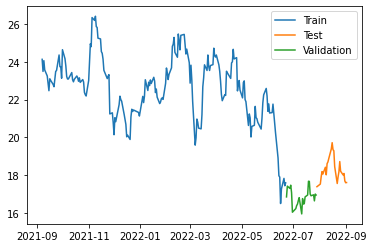

In [21]:
trainSplit = int(len(dates) * 0.8)
testSplit = int(len(dates) * 0.9)

train_dates, train_X, train_y = dates[:trainSplit], X[:trainSplit], y[:trainSplit]
test_dates, test_X, test_y = dates[testSplit:], X[testSplit:], y[testSplit:]
val_dates, val_X, val_y = dates[trainSplit:testSplit], X[trainSplit:testSplit], y[trainSplit:testSplit]

plt.plot(train_dates, train_y)
plt.plot(test_dates, test_y)
plt.plot(val_dates, val_y)

plt.legend(['Train', 'Test', 'Validation'])

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 96ms/step - loss: 518.9525 - mean_absolute_error: 22.7127 - val_loss: 276.2426 - val_mean_absolute_error: 16.6145
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 496.7097 - mean_absolute_error: 22.2192 - val_loss: 260.5733 - val_mean_absolute_error: 16.1361
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 474.8699 - mean_absolute_error: 21.7196 - val_loss: 243.1099 - val_mean_absolute_error: 15.5856
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 448.9574 - mean_absolute_error: 21.1161 - val_loss: 220.3148 - val_mean_absolute_error: 14.8363
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 414.8567 - mean_absolute_error: 20.2897 - val_loss: 189.0336 - val_mean_absolute_error: 13.7417
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 366.9384 - mean_absolute_error: 19.0681 - val_loss: 148.0315 - val_mean_absolute_error: 12.15

7/7 [==============================] - 0s 2ms/step


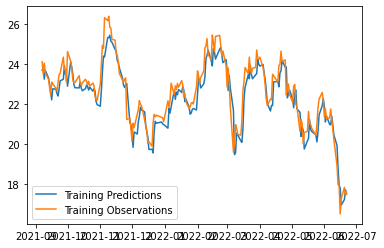

In [23]:
trainPredictions = model.predict(train_X).flatten()

plt.plot(train_dates, trainPredictions)
plt.plot(train_dates, train_y)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 26ms/step


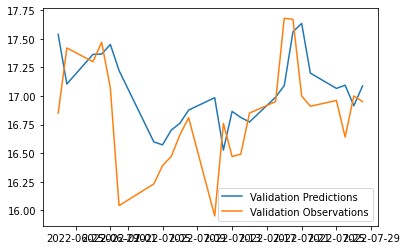

In [24]:
valPredictions = model.predict(val_X).flatten()

plt.plot(val_dates, valPredictions)
plt.plot(val_dates, val_y)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 23ms/step


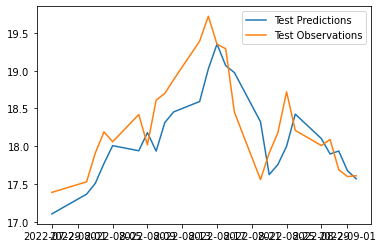

In [25]:
testPredictions = model.predict(test_X).flatten()

plt.plot(test_dates, testPredictions)
plt.plot(test_dates, test_y)
plt.legend(['Test Predictions', 'Test Observations'])

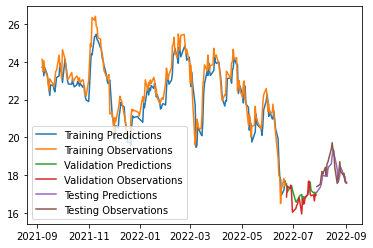

In [26]:
plt.plot(train_dates, trainPredictions)
plt.plot(train_dates, train_y)
plt.plot(val_dates, valPredictions)
plt.plot(val_dates, val_y)
plt.plot(test_dates, testPredictions)
plt.plot(test_dates, test_y)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [30]:
from copy import deepcopy

recursivePredictions = []
recursiveDates = np.concatenate([val_dates, test_dates])

for tarDate in recursiveDates:
    last = deepcopy(train_X[-1])
    nextPrediction = model.predict(np.array([last])).flatten()
    recursivePredictions.append(nextPrediction)
    last[-1] = nextPrediction

1/1 [==============================] - 0s 21ms/step


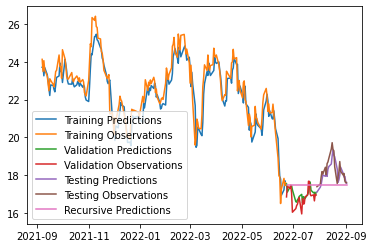

In [31]:
plt.plot(train_dates, trainPredictions)
plt.plot(train_dates, train_y)
plt.plot(val_dates, valPredictions)
plt.plot(val_dates, val_y)
plt.plot(test_dates, testPredictions)
plt.plot(test_dates, test_y)
plt.plot(recursiveDates, recursivePredictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])